In [1]:
import os

import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interp
import scipy.ndimage as ndi

%matplotlib inline
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

from migdalcalc import migdalcalc as mc
from migdalcalc.migdal import kinematics as kin

In [2]:
Xe_migdal = mc.migdalcalc(target="Xe-131", nuclear_data_name="jendl40")

In [3]:
def interp_csv(file_name, skip_header=0):
    plot_data = np.genfromtxt(file_name, delimiter=',', skip_header=skip_header)
    x = list(zip(*plot_data))[0]
    y = list(zip(*plot_data))[1]
    
    return interp.interp1d(x, y, bounds_error=False, fill_value = 0, kind='linear')

In [4]:
A = Xe_migdal.A
N_per_kg = (6.02e26/A)
barns_to_cm2 = 1e-24
flux = 100 #nuetrons/cm^2/second

xsec_to_inv_kg_seconds = flux*N_per_kg*barns_to_cm2

In [5]:
En_range = np.geomspace(1e3, 1e6, 3000)
migdal_xsec_arr = []

for En in En_range:
    migdal_spectrum = Xe_migdal.dR_dDeltaE_HS(En, flux=xsec_to_inv_kg_seconds)
    
    dE_range = np.geomspace(1e-3, kin.DeltaE_Max(Xe_migdal.A, En), 1001)
    samples = migdal_spectrum(dE_range)
    
    migdal_xsec = integrate.trapezoid(samples, dE_range)
    migdal_xsec_arr.append(migdal_xsec)
    
bell_migdal = interp_csv('./input/bell/migdal.csv')
bell_pts = bell_migdal.x

bell_elastic = interp_csv('./input/bell/elastic.csv')

duncan_elastic = lambda En: xsec_to_inv_kg_seconds*Xe_migdal.nuc.SIG(En)
duncan_migdal = interp.interp1d(En_range, migdal_xsec_arr, bounds_error=False, fill_value = 0, kind='linear')

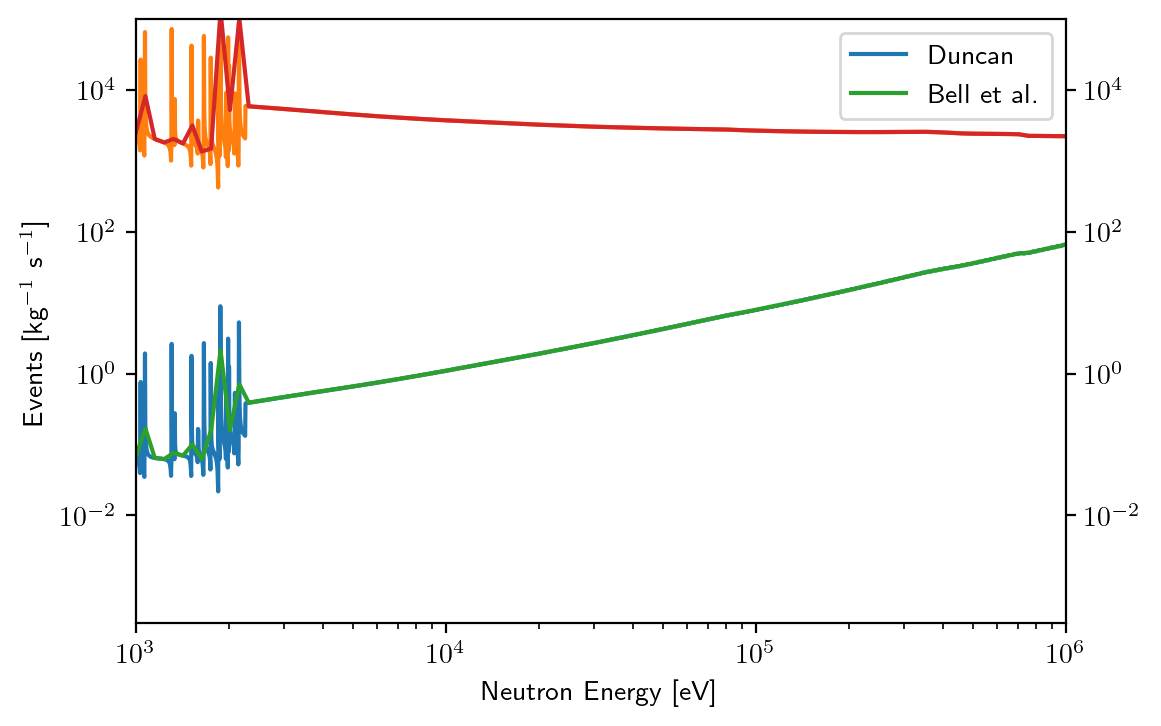

In [6]:
plt.plot(En_range, migdal_xsec_arr, label="Duncan")
plt.plot(En_range, duncan_elastic(En_range))
plt.plot(np.multiply(bell_pts, 1e3), bell_migdal(bell_pts), label="Bell et al.")
plt.plot(np.multiply(bell_pts, 1e3), bell_elastic(bell_pts))
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Neutron Energy [eV]')
plt.ylabel(r'Events [kg$^{-1}$ s$^{-1}$]')
plt.tick_params(labelright=True, right=True)
plt.ylim(3e-4, 1e5)
plt.xlim(1e3, 1e6)
plt.show()

In [7]:
for En in En_range:
    print(bell_migdal(En*1e-3)/(duncan_migdal(En)))

0.995977970778149
1.0965570054823848
1.1911502594220498
1.2834151574559478
1.3699434799954526
1.4555098115792433
1.5423302803127614
1.63357597668588
1.7294799587993652
1.835257888355522
1.9676051427164964
2.13118287034446
2.3659980204207853
2.8095017099674218
1.5489809552505662
0.15432136211266564
1.4299549931148765
1.8088649463863926
2.030694468670333
2.216394808194909
2.3905949310009538
2.57069436327216
2.7565121145051337
2.970653157523206
3.248798482106315
3.637552997178772
4.20706457055461
4.505310623681606
0.4277587179227826
0.08513645717215818
0.8217536832206012
1.3150163662844971
1.5785878039792705
1.730493726564083
1.822204020181374
1.8728765145083581
1.899908967256311
1.9184596570843782
1.9244921929184762
1.9204062430829112
1.9039564454736262
1.876631784933426
1.8459477599284138
1.8114807933072143
1.7736479264057678
1.7351094090501662
1.7015525580213842
1.665555618288708
1.629005075051685
1.583557580849254
1.5350449032443045
1.4861836542892028
1.4362675260148197
1.384297634490

In [8]:
migdal_prob = lambda E: Xe_migdal.mig.dP_dDeltaE(E)*511**2

In [9]:
integrate.quad(migdal_prob, 0, 4000, limit=200, epsrel=1e-3)

(0.12059094789551127, 8.46778909294188e-06)

In [10]:
0.00119/0.000984

1.209349593495935